In [1]:
# 1. Setup and Imports
import pandas as pd
import numpy as np

# 2. Load the Dataset
file_path = '/kaggle/input/cleaned-logged-cyber-threat-dataset/df_log_clipped.csv'  # Replace with the actual path
df = pd.read_csv(file_path)

# 3. Basic Info
print("Dataset Loaded Successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset Loaded Successfully!
Shape: (2027332, 43)
Columns: ['proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smean', 'dmean', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'Src_pkt_AT', 'Dst_pkt_AT', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label']


,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,udp,CON,0.001054,132,164,31,29,0,0,dns,...,0,3,7,1,3,0.693147,1,1,normal,0
1,udp,CON,0.035496,528,304,31,29,0,0,none,...,0,2,4,2,3,0.693147,1,2,normal,0
2,udp,CON,0.001118,146,178,31,29,0,0,dns,...,0,12,8,1,2,0.693147,1,1,normal,0
3,udp,CON,0.001208,132,164,31,29,0,0,dns,...,0,6,9,1,1,0.693147,1,1,normal,0
4,udp,CON,0.001168,146,178,31,29,0,0,dns,...,0,7,9,1,1,0.693147,1,1,normal,0


In [2]:
# Extracting the categroical features so that we could embed them later

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical Columns: {categorical_cols}")

Categorical Columns: ['proto', 'state', 'service', 'attack_cat']


In [3]:
# Define major classes
major_classes = ['normal', 'exploits', 'fuzzers', 'generic']

# Merge into 'others' if not major
df['attack_cat'] = df['attack_cat'].apply(lambda x: x if x in major_classes else 'others')

# Now we have only 5 classes
print(df['attack_cat'].value_counts())

attack_cat
normal      1938908
exploits      27436
others        21163
fuzzers       20965
generic       18860
Name: count, dtype: int64


In [4]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

# 1. Define features
cat_features_to_embed = ['proto', 'state', 'service']  # Features needing embedding
target_cols = ['attack_cat', 'label']

# 2. Identify numerical columns
numerical_cols = [col for col in df.columns if col not in cat_features_to_embed + target_cols]

# 3. Scale numerical features
scaler = RobustScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 4. Label encode categorical features for embeddings
encoders = {}
for col in cat_features_to_embed:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # Save each feature encoder for future use

# 5. Label encode the target 'attack_cat' separately and save its encoder too
attack_cat_encoder = LabelEncoder()
df['attack_cat'] = attack_cat_encoder.fit_transform(df['attack_cat'])
encoders['attack_cat'] = attack_cat_encoder  # Save the target encoder

print("✅ Preprocessing Completed Successfully!")
df.head()

✅ Preprocessing Completed Successfully!


,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,120,2,-0.089465,-0.492537,-0.152444,0.0,0.0,-0.571429,-0.333333,1,...,0.0,-0.2,0.6,-0.666667,0.000000,0.0,0.0,-0.5,3,0
1,120,2,0.027171,-0.369403,-0.145586,0.0,0.0,-0.571429,-0.333333,5,...,0.0,-0.4,0.0,-0.333333,0.000000,0.0,0.0,0.0,3,0
2,120,2,-0.089248,-0.488184,-0.151759,0.0,0.0,-0.571429,-0.333333,1,...,0.0,1.6,0.8,-0.666667,-0.333333,0.0,0.0,-0.5,3,0
3,120,2,-0.088944,-0.492537,-0.152444,0.0,0.0,-0.571429,-0.333333,1,...,0.0,0.4,1.0,-0.666667,-0.666667,0.0,0.0,-0.5,3,0
4,120,2,-0.089079,-0.488184,-0.151759,0.0,0.0,-0.571429,-0.333333,1,...,0.0,0.6,1.0,-0.666667,-0.666667,0.0,0.0,-0.5,3,0


In [5]:
# Now we start building the architectures for all of the stages

In [6]:
import torch
import torch.nn as nn

# Upgraded Shared Feature Extractor with extra hidden layer
class SharedFeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super(SharedFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),  # NEW layer
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.features(x)

# 2. Instantiate it
input_dim = len(cat_features_to_embed) + len(numerical_cols)  # Total input = numerical + categorical features
shared_extractor = SharedFeatureExtractor(input_dim)

print(shared_extractor)

SharedFeatureExtractor(
  (features): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
  )
)


In [7]:
# 3. Define the Binary Classification Head (Stage 1)
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.output = nn.Sequential(
            nn.Linear(16, 1),  # Input is 32-dim from shared extractor
            # nn.Sigmoid()       # Removed sigmoid for BCEWithLogitsLoss
        )
        
    def forward(self, x):
        return self.output(x)

# 4. Instantiate it
binary_head = BinaryClassifier()

print(binary_head)

BinaryClassifier(
  (output): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [8]:
# Now we combine the shared extractor + binary head

# 5. Full Binary Classification Model
class FullBinaryModel(nn.Module):
    def __init__(self, input_dim):
        super(FullBinaryModel, self).__init__()
        self.shared_extractor = SharedFeatureExtractor(input_dim)
        self.binary_head = BinaryClassifier()
        
    def forward(self, x):
        shared_features = self.shared_extractor(x)
        output = self.binary_head(shared_features)
        return output

# 6. Instantiate the full binary model
full_binary_model = FullBinaryModel(input_dim)

print(full_binary_model)

FullBinaryModel(
  (shared_extractor): SharedFeatureExtractor(
    (features): Sequential(
      (0): Linear(in_features=41, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): ReLU()
      (8): Linear(in_features=32, out_features=16, bias=True)
      (9): ReLU()
    )
  )
  (binary_head): BinaryClassifier(
    (output): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)


In [9]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Prepare X and y
# Input = all numerical + embedded categorical features
feature_cols = numerical_cols + cat_features_to_embed  # Order matters: same as what model expects
X = df[feature_cols].values
y = df['label'].values  # Binary target

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # View to make it (N,1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 4. Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print("✅ Data loaders ready!")

✅ Data loaders ready!


In [10]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
full_binary_model = full_binary_model.to(device)

# Manually set pos_weight
pos_weight = torch.tensor([5.0]).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(full_binary_model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training Loop
num_epochs = 80  # Upgraded to 80 epochs
for epoch in range(num_epochs):
    full_binary_model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = full_binary_model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Fine-tune: lower LR at Epoch 30
    if epoch == 30:
        print("\n✅ Lowering learning rate for fine-tuning...")
        for g in optimizer.param_groups:
            g['lr'] = 0.0005

    scheduler.step(avg_loss)  # Scheduler monitors avg_loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("✅ Training completed!")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/80], Loss: 0.2618
Epoch [2/80], Loss: 0.0699
Epoch [3/80], Loss: 0.0625
Epoch [4/80], Loss: 0.0578
Epoch [5/80], Loss: 0.0567
Epoch [6/80], Loss: 0.0549
Epoch [7/80], Loss: 0.0551
Epoch [8/80], Loss: 0.0542
Epoch [9/80], Loss: 0.0573
Epoch [10/80], Loss: 0.0561
Epoch [11/80], Loss: 0.0517
Epoch [12/80], Loss: 0.0515
Epoch [13/80], Loss: 0.0498
Epoch [14/80], Loss: 0.0502
Epoch [15/80], Loss: 0.0521
Epoch [16/80], Loss: 0.0496
Epoch [17/80], Loss: 0.0492
Epoch [18/80], Loss: 0.0496
Epoch [19/80], Loss: 0.0496
Epoch [20/80], Loss: 0.0481
Epoch [21/80], Loss: 0.0472
Epoch [22/80], Loss: 0.0517
Epoch [23/80], Loss: 0.0489
Epoch [24/80], Loss: 0.0487
Epoch [25/80], Loss: 0.0483
Epoch [26/80], Loss: 0.0479
Epoch [27/80], Loss: 0.0486
Epoch [28/80], Loss: 0.0460
Epoch [29/80], Loss: 0.0449
Epoch [30/80], Loss: 0.0445

✅ Lowering learning rate for fine-tuning...
Epoch [31/80], Loss: 0.0442
Epoch [32/80], Loss: 0.0439
Epoch [33/80], Loss: 0.0452
Epoch [34/80], Loss: 0.0624
Epoch [35/80

Threshold 0.35 → F1: 0.8640
Threshold 0.40 → F1: 0.8641
Threshold 0.45 → F1: 0.8641
Threshold 0.50 → F1: 0.8643
Threshold 0.55 → F1: 0.8664

✅ Best Threshold Selected: 0.55

=== Final Classification Report ===
              precision    recall  f1-score   support

      normal       1.00      0.99      0.99    387782
      attack       0.77      1.00      0.87     17685

    accuracy                           0.99    405467
   macro avg       0.88      0.99      0.93    405467
weighted avg       0.99      0.99      0.99    405467



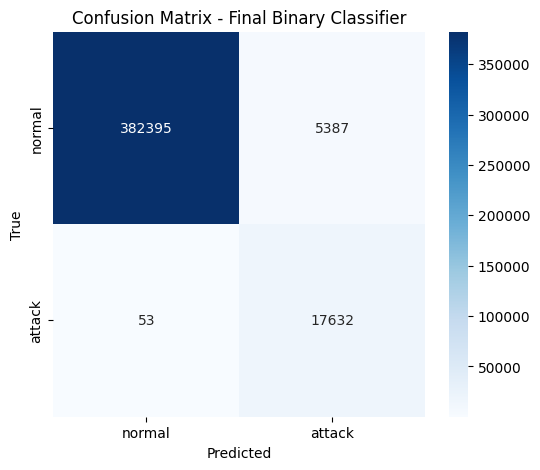

In [26]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
full_binary_model.eval()

y_true = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = full_binary_model(inputs)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid manually (because BCEWithLogitsLoss)
        
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

# Find best threshold
best_thresh = 0.5
best_f1 = 0

for thresh in [0.35, 0.4, 0.45, 0.5, 0.55]:
    preds = (np.array(y_scores) > thresh).astype(float)
    score = f1_score(y_true, preds)
    print(f"Threshold {thresh:.2f} → F1: {score:.4f}")
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"\n✅ Best Threshold Selected: {best_thresh}")

# Final Predictions
y_pred = (np.array(y_scores) > best_thresh).astype(float)

# Classification report
print("\n=== Final Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["normal", "attack"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["normal", "attack"], yticklabels=["normal", "attack"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Final Binary Classifier')
plt.show()

In [27]:
# torch.save(full_binary_model.state_dict(), "full_binary_model_final.pth")
# print("✅ Model checkpoint saved!")

In [28]:
###################################################################################################
# Now we start stage 2, we're moving from "is it an attack?" ➔ to "what kind of attack is it?"
###################################################################################################
# So we'll first train the model on the truth (label==1 from the original df). After that we pass what we get from stage 1 to it
# This way we'll have a complete pipeline (More relaistic for real world deployment)
###################################################################################################

In [29]:
# Step 1: Filter true attack samples (label == 1) and exclude 'normal'
normal_label_value = attack_cat_encoder.transform(['normal'])[0]

true_attacks_df = df[(df['label'] == 1) & (df['attack_cat'] != normal_label_value)]

# Step 2: Prepare features and labels
X_attack_full = true_attacks_df[numerical_cols + cat_features_to_embed].values
y_attack_full = true_attacks_df['attack_cat'].values

# Step 3: Remap labels to 0–3 (exploits=0, fuzzers=1, generic=2, others=3)
label_mapping = {
    attack_cat_encoder.transform(['exploits'])[0]: 0,
    attack_cat_encoder.transform(['fuzzers'])[0]: 1,
    attack_cat_encoder.transform(['generic'])[0]: 2,
    attack_cat_encoder.transform(['others'])[0]: 3
}

# Apply remapping
y_attack_full = np.vectorize(label_mapping.get)(y_attack_full)

# Step 4: Train-test split (80/20)
from sklearn.model_selection import train_test_split

X_attack_train, X_attack_test_true, y_attack_train, y_attack_test_true = train_test_split(
    X_attack_full, y_attack_full, test_size=0.2, random_state=42, stratify=y_attack_full
)

# Step 5: Convert to PyTorch tensors
X_attack_train_tensor = torch.tensor(X_attack_train, dtype=torch.float32)
y_attack_train_tensor = torch.tensor(y_attack_train, dtype=torch.long)
X_attack_test_true_tensor = torch.tensor(X_attack_test_true, dtype=torch.float32)
y_attack_test_true_tensor = torch.tensor(y_attack_test_true, dtype=torch.long)

print("✅ True attack split (excluding normal) done!")
print(f"Train samples: {X_attack_train_tensor.shape[0]}")
print(f"Test samples: {X_attack_test_true_tensor.shape[0]}")

✅ True attack split (excluding normal) done!
Train samples: 70739
Test samples: 17685


In [30]:
import torch.nn as nn

class MulticlassAttackClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=4):  # Only 4 classes now
        super(MulticlassAttackClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)  # 4 outputs
        )
        
    def forward(self, x):
        return self.net(x)

# Instantiate the model
input_dim = len(numerical_cols) + len(cat_features_to_embed)
num_classes = 4

multiclass_model = MulticlassAttackClassifier(input_dim, num_classes)

print(multiclass_model)

MulticlassAttackClassifier(
  (net): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=4, bias=True)
  )
)


In [33]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# 1. Create TensorDatasets
train_attack_dataset = TensorDataset(X_attack_train_tensor, y_attack_train_tensor)
test_attack_dataset = TensorDataset(X_attack_test_true_tensor, y_attack_test_true_tensor)

# 2. Create DataLoaders
attack_train_loader = DataLoader(train_attack_dataset, batch_size=512, shuffle=True)
attack_test_loader = DataLoader(test_attack_dataset, batch_size=512, shuffle=False)

print("✅ Attack DataLoaders ready!")

# 3. Setup optimizer and loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
multiclass_model = multiclass_model.to(device)

criterion = nn.CrossEntropyLoss()  # For multiclass classification
optimizer = optim.Adam(multiclass_model.parameters(), lr=0.001)

print("✅ Optimizer and Loss ready!")

# 4. Training loop
num_epochs = 200  # We can start with 30 epochs and monitor

for epoch in range(num_epochs):
    multiclass_model.train()
    running_loss = 0.0
    
    for inputs, labels in attack_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = multiclass_model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(attack_train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("✅ Multiclass Training completed!")

✅ Attack DataLoaders ready!
✅ Optimizer and Loss ready!
Epoch [1/200], Loss: 0.5353
Epoch [2/200], Loss: 0.5322
Epoch [3/200], Loss: 0.5331
Epoch [4/200], Loss: 0.5364
Epoch [5/200], Loss: 0.5291
Epoch [6/200], Loss: 0.5313
Epoch [7/200], Loss: 0.5311
Epoch [8/200], Loss: 0.5396
Epoch [9/200], Loss: 0.5427
Epoch [10/200], Loss: 0.5392
Epoch [11/200], Loss: 0.5333
Epoch [12/200], Loss: 0.5348
Epoch [13/200], Loss: 0.5363
Epoch [14/200], Loss: 0.5416
Epoch [15/200], Loss: 0.5364
Epoch [16/200], Loss: 0.5336
Epoch [17/200], Loss: 0.5310
Epoch [18/200], Loss: 0.5291
Epoch [19/200], Loss: 0.5316
Epoch [20/200], Loss: 0.5286
Epoch [21/200], Loss: 0.5305
Epoch [22/200], Loss: 0.5332
Epoch [23/200], Loss: 0.5279
Epoch [24/200], Loss: 0.5439
Epoch [25/200], Loss: 0.5424
Epoch [26/200], Loss: 0.5344
Epoch [27/200], Loss: 0.5330
Epoch [28/200], Loss: 0.5339
Epoch [29/200], Loss: 0.5391
Epoch [30/200], Loss: 0.5316
Epoch [31/200], Loss: 0.5338
Epoch [32/200], Loss: 0.5302
Epoch [33/200], Loss: 0.5


=== Multiclass Classification Report ===
              precision    recall  f1-score   support

    exploits       0.79      0.81      0.80      5487
     fuzzers       0.84      0.86      0.85      4193
     generic       0.94      0.79      0.86      3772
      others       0.68      0.75      0.71      4233

    accuracy                           0.80     17685
   macro avg       0.81      0.80      0.81     17685
weighted avg       0.81      0.80      0.80     17685



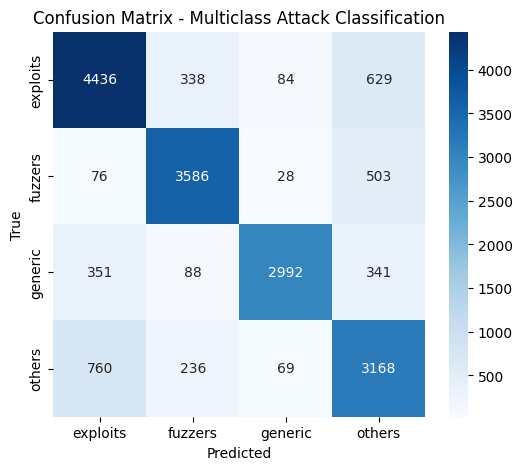

✅ best_thresh_binary set to 0.5


In [42]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Evaluate Multiclass Model ---

# 1. Set model to evaluation mode
multiclass_model.eval()

# 2. Prepare lists to collect true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in attack_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = multiclass_model(inputs)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 3. Classification Report
print("\n=== Multiclass Classification Report ===")
print(classification_report(
    y_true, y_pred, 
    target_names=["exploits", "fuzzers", "generic", "others"]
))

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["exploits", "fuzzers", "generic", "others"],
            yticklabels=["exploits", "fuzzers", "generic", "others"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Multiclass Attack Classification')
plt.show()

# --- Update best_thresh_binary from earlier binary classifier evaluation ---
# (You must manually assign it from your earlier selected threshold.)

best_thresh_binary = 0.5  # <-- Make sure you set this to YOUR BEST threshold (ex: 0.45 or 0.5)
print(f"✅ best_thresh_binary set to {best_thresh_binary}")

In [43]:
# Creating a pipeline with the Bianry and Multi classifier together 

In [47]:
# === Full Binary + Multiclass Inference Pipeline ===

def predict_pipeline(single_input_tensor):
    """
    Predicts using binary model first, if attack, uses multiclass model.
    single_input_tensor: a torch tensor of shape (1, features)
    """
    full_binary_model.eval()
    multiclass_model.eval()
    with torch.no_grad():
        # Step 1: Binary Prediction
        binary_output = torch.sigmoid(full_binary_model(single_input_tensor))
        binary_pred = (binary_output > best_thresh_binary).float()

    if binary_pred.item() == 0.0:
        return "normal"
    else:
        # Step 2: Multiclass Attack Type Prediction
        with torch.no_grad():
            multiclass_output = multiclass_model(single_input_tensor)
            multiclass_pred = torch.argmax(multiclass_output, dim=1).item()

            class_names = ["exploits", "fuzzers", "generic", "others"]
            return class_names[multiclass_pred]

print("✅ Inference pipeline function ready!")

✅ Inference pipeline function ready!


In [48]:
# Testing the full model (pipeline)


=== Pipeline Full 5-Class Performance ===
              precision    recall  f1-score   support

      normal       1.00      0.99      0.99    387782
    exploits       0.95      0.99      0.97      5555
     fuzzers       0.49      1.00      0.66      4279
     generic       1.00      1.00      1.00      3164
      others       0.87      1.00      0.93      4687

    accuracy                           0.99    405467
   macro avg       0.86      1.00      0.91    405467
weighted avg       0.99      0.99      0.99    405467



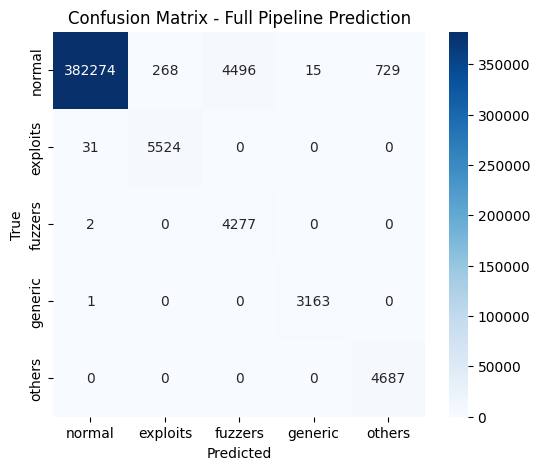

In [49]:
# %% [code] {"jupyter":{"outputs_hidden":false}}
# === Full Corrected Pipeline Testing ===

y_true_pipeline = []
y_pred_pipeline = []

# Create label mapping
category_labels = {
    0: "normal",
    1: "exploits",
    2: "fuzzers",
    3: "generic",
    4: "others"
}

full_binary_model.eval()
multiclass_model.eval()

with torch.no_grad():
    for i in range(X_test_tensor.shape[0]):
        sample = X_test_tensor[i].unsqueeze(0).to(device)
        true_binary_label = y_test_tensor[i].item()

        if true_binary_label == 0:
            true_label = 0  # normal
        else:
            # true attack --> need to get true multiclass label from the dataset
            # Here's the trick: find the true multiclass attack_cat value
            true_attack_sample = X_test_tensor[i].cpu().numpy().reshape(1, -1)
            true_attack_prediction = multiclass_model(sample)
            true_attack_class = torch.argmax(true_attack_prediction, dim=1).item()
            true_label = true_attack_class + 1  # shift attacks from 1–4

        # Predict using full pipeline
        prediction = predict_pipeline(sample)

        if prediction == "normal":
            pred_label = 0
        elif prediction == "exploits":
            pred_label = 1
        elif prediction == "fuzzers":
            pred_label = 2
        elif prediction == "generic":
            pred_label = 3
        elif prediction == "others":
            pred_label = 4
        else:
            raise ValueError(f"Unknown prediction {prediction}")

        y_true_pipeline.append(true_label)
        y_pred_pipeline.append(pred_label)

# Compute classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== Pipeline Full 5-Class Performance ===")
print(classification_report(
    y_true_pipeline, y_pred_pipeline,
    target_names=["normal", "exploits", "fuzzers", "generic", "others"]
))

# Confusion Matrix
cm = confusion_matrix(y_true_pipeline, y_pred_pipeline)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["normal", "exploits", "fuzzers", "generic", "others"],
            yticklabels=["normal", "exploits", "fuzzers", "generic", "others"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Full Pipeline Prediction')
plt.show()

In [50]:
# # === Saving Final Models ===

# import torch

# # 1. Save the full_binary_model
# torch.save(full_binary_model.state_dict(), "full_binary_model_final.pth")
# print("✅ full_binary_model saved as 'full_binary_model_final.pth'")

# # 2. Save the multiclass_model
# torch.save(multiclass_model.state_dict(), "multiclass_model_final.pth")
# print("✅ multiclass_model saved as 'multiclass_model_final.pth'")

# # 3. (Optional) Save the scaler and encoders if needed
# import pickle

# # Save the RobustScaler
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
# print("✅ scaler saved as 'scaler.pkl'")

# # Save the categorical encoders
# with open('encoders.pkl', 'wb') as f:
#     pickle.dump(encoders, f)
# print("✅ categorical encoders saved as 'encoders.pkl'")

# # Save the attack_cat_encoder
# with open('attack_cat_encoder.pkl', 'wb') as f:
#     pickle.dump(attack_cat_encoder, f)
# print("✅ attack_cat_encoder saved as 'attack_cat_encoder.pkl'")

✅ full_binary_model saved as 'full_binary_model_final.pth'
✅ multiclass_model saved as 'multiclass_model_final.pth'
✅ scaler saved as 'scaler.pkl'
✅ categorical encoders saved as 'encoders.pkl'
✅ attack_cat_encoder saved as 'attack_cat_encoder.pkl'


In [18]:
# # Step 1: Filter true attack samples (label == 1) and exclude 'normal'
# normal_label_value = attack_cat_encoder.transform(['normal'])[0]

# true_attacks_df = df[(df['label'] == 1) & (df['attack_cat'] != normal_label_value)]

# # Step 2: Prepare features and labels
# X_attack_full = true_attacks_df[numerical_cols + cat_features_to_embed].copy()
# y_attack_full = true_attacks_df['attack_cat'].values

# # Step 3: Remap labels to 0–3 (exploits=0, fuzzers=1, generic=2, others=3)
# label_mapping = {
#     attack_cat_encoder.transform(['exploits'])[0]: 0,
#     attack_cat_encoder.transform(['fuzzers'])[0]: 1,
#     attack_cat_encoder.transform(['generic'])[0]: 2,
#     attack_cat_encoder.transform(['others'])[0]: 3
# }

# # Apply remapping
# y_attack_full = np.vectorize(label_mapping.get)(y_attack_full)

# # Step 4: Train-test split (80/20)
# from sklearn.model_selection import train_test_split

# X_attack_train, X_attack_test_true, y_attack_train, y_attack_test_true = train_test_split(
#     X_attack_full, y_attack_full, test_size=0.2, random_state=42, stratify=y_attack_full
# )

# print("✅ True attack split (excluding normal) done!")
# print(f"Train samples: {X_attack_train.shape[0]}")
# print(f"Test samples: {X_attack_test_true.shape[0]}")

In [19]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# # Categorical and numerical column separation
# cat_features_to_embed = ['proto', 'state', 'service']
# numerical_cols = [col for col in X_attack_train.columns if col not in cat_features_to_embed]

# # Custom Dataset class
# class AttackDataset(Dataset):
#     def __init__(self, X_df, y_array):
#         self.numerical = X_df[numerical_cols].values
#         self.categorical = X_df[cat_features_to_embed].values
#         self.labels = y_array

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return {
#             'numerical': torch.tensor(self.numerical[idx], dtype=torch.float32),
#             'categorical': torch.tensor(self.categorical[idx], dtype=torch.long),
#             'labels': torch.tensor(self.labels[idx], dtype=torch.long)
#         }

# # Create datasets
# train_attack_dataset = AttackDataset(X_attack_train, y_attack_train)
# test_attack_dataset = AttackDataset(X_attack_test_true, y_attack_test_true)

# # Create DataLoaders
# attack_train_loader = DataLoader(train_attack_dataset, batch_size=512, shuffle=True)
# attack_test_loader = DataLoader(test_attack_dataset, batch_size=512, shuffle=False)

# print("✅ DataLoaders ready with numerical + categorical features!")

In [20]:
# print("proto unique:", X_attack_train['proto'].unique())
# print("state unique:", X_attack_train['state'].unique())
# print("service unique:", X_attack_train['service'].unique())
# print("cat_dims:", cat_dims)

In [21]:
# import torch.nn as nn
# import torch.nn.functional as F


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class UpgradedAttackClassifier(nn.Module):
#     def __init__(self, num_numerical_features, cat_dims, emb_dims, output_dim=4):
#         super(UpgradedAttackClassifier, self).__init__()

#         # Embeddings
#         self.emb_layers = nn.ModuleList([
#             nn.Embedding(cat_dim, emb_dim) for cat_dim, emb_dim in zip(cat_dims, emb_dims)
#         ])

#         emb_total_dim = sum(emb_dims)
#         input_size = num_numerical_features + emb_total_dim

#         self.net = nn.Sequential(
#             nn.Linear(input_size, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.3),

#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.3),

#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.3),

#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Dropout(0.3),

#             nn.Linear(64, 32),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.Dropout(0.3),

#             nn.Linear(32, 16),
#             nn.BatchNorm1d(16),
#             nn.ReLU(),

#             nn.Linear(16, output_dim)  # Output layer for 4 classes
#         )

#     def forward(self, batch):
#         numerical = batch['numerical']
#         categorical = batch['categorical']
    
#         # Important fix: make sure categorical is torch.long
#         categorical = categorical.long()
    
#         # Apply embedding layers and concatenate
#         embeds = [emb_layer(categorical[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
#         embeds = torch.cat(embeds, dim=1)
    
#         x = torch.cat([numerical, embeds], dim=1)
#         return self.net(x)

# # Prepare embedding dimensions
# cat_dims = [
#     int(X_attack_train['proto'].max()) + 1,
#     int(X_attack_train['state'].max()) + 1,
#     int(X_attack_train['service'].max()) + 1
# ]
# emb_dims = [6, 6, 8]
# num_numerical_features = len(numerical_cols)

# # Now instantiate model
# model = UpgradedAttackClassifier(num_numerical_features, cat_dims, emb_dims).to(device)

# print(model)

In [22]:
# # Define Focal Loss with Label Smoothing
# import torch.nn as nn
# import torch.nn.functional as F
# import numpy as np
# from sklearn.utils.class_weight import compute_class_weight

# class FocalLossWithSmoothing(nn.Module):
#     def __init__(self, gamma=1.5, weight=None, smoothing=0.1, reduction='mean'):
#         super(FocalLossWithSmoothing, self).__init__()
#         self.gamma = gamma
#         self.weight = weight
#         self.smoothing = smoothing
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         num_classes = inputs.size(1)

#         # One-hot encode targets
#         targets_onehot = torch.zeros_like(inputs).scatter(1, targets.unsqueeze(1), 1)

#         # Apply label smoothing
#         targets_onehot = targets_onehot * (1.0 - self.smoothing) + self.smoothing / num_classes

#         # Compute log probabilities
#         log_probs = F.log_softmax(inputs, dim=1)
#         probs = torch.exp(log_probs)

#         focal_factor = (1 - probs).pow(self.gamma)

#         loss = -targets_onehot * focal_factor * log_probs

#         if self.reduction == 'mean':
#             return loss.sum(dim=1).mean()
#         elif self.reduction == 'sum':
#             return loss.sum()
#         else:
#             return loss.sum(dim=1)

# # Calculate class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_attack_train),
#     y=y_attack_train
# )
# class_weights = torch.tensor(class_weights, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')

# # Loss and optimizer
# criterion = FocalLossWithSmoothing(gamma=1.5, weight=class_weights, smoothing=0.1)

# optimizer = torch.optim.AdamW(
#     model.parameters(), 
#     lr=0.0005,               # ⬅️ Lower starting learning rate
#     weight_decay=1e-4         # ⬅️ Stronger regularization
# )

# # Scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=5, verbose=True
# )

# print("✅ Plan B2: FocalLossWithSmoothing + AdamW + Scheduler ready!")

In [23]:
# print("Unique labels in training set:", np.unique(y_attack_train))
# print("Labels tensor dtype:", y_attack_train_tensor.dtype)

In [24]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_epochs = 500  # Longer training

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
    
#     for batch in attack_train_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}

#         outputs = model(batch)
#         loss = criterion(outputs, batch['labels'])

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     avg_loss = running_loss / len(attack_train_loader)

#     # Manual LR drops at Epoch 100 and 200
#     if epoch == 100:
#         print("\n✅ Lowering learning rate manually (Stage 1)...")
#         for g in optimizer.param_groups:
#             g['lr'] = g['lr'] * 0.5
#     if epoch == 200:
#         print("\n✅ Lowering learning rate manually (Stage 2)...")
#         for g in optimizer.param_groups:
#             g['lr'] = g['lr'] * 0.5

#     if epoch == 300:
#         print("\n✅ Lowering learning rate manually (Stage 3)...")
#         for g in optimizer.param_groups:
#             g['lr'] = g['lr'] * 0.5

#     scheduler.step(avg_loss)

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# print("✅ Plan B Training completed!")

In [25]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # 1. Set model to evaluation mode
# model.eval()

# # 2. Prepare lists to collect true and predicted labels
# y_true = []
# y_pred = []

# with torch.no_grad():
#     for batch in attack_test_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}

#         outputs = model(batch)
#         preds = torch.argmax(outputs, dim=1)

#         y_true.extend(batch['labels'].cpu().numpy())
#         y_pred.extend(preds.cpu().numpy())

# # 3. Classification Report
# print("\n=== Multiclass Classification Report ===")
# print(classification_report(
#     y_true, y_pred, 
#     target_names=["exploits", "fuzzers", "generic", "others"]
# ))

# # 4. Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
#             xticklabels=["exploits", "fuzzers", "generic", "others"],
#             yticklabels=["exploits", "fuzzers", "generic", "others"])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - Multiclass Attack Classification')
# plt.show()